In [ ]:
!pip install --upgrade dtreeviz

In [1]:
pip install -q -U tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 18.3 MB/s eta 0:00:00


In [2]:
!pip install -q -U dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.8 MB/s eta 0:00:00


In [3]:
import tensorflow_decision_forests as tfdf

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

import dtreeviz

from matplotlib import pyplot as plt
from IPython import display

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats('retina') # generate hires plots

np.random.seed(1234)  # reproducible plots/data for explanatory reasons

<ipython-input-3-85acafa886c3>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [4]:
# Let's check the versions:
tfdf.__version__, dtreeviz.__version__  # want dtreeviz >= 2.2.0

('1.9.2', '2.2.2')

In [5]:
def split_dataset(dataset, test_ratio=0.30, seed=1234):
  """
  Splits a panda dataframe in two, usually for train/test sets.
  Using the same random seed ensures we get the same split so
  that the description in this tutorial line up with generated images.
  """
  np.random.seed(seed)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

Visualizing Classifier Trees

In [10]:
# Download the Penguins dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
df_penguins = pd.read_csv("/tmp/penguins.csv")
df_penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


In [11]:
df_penguins.columns[df_penguins.isna().any()].tolist()

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

In [12]:
df_penguins = df_penguins.dropna() # E.g., 19 rows have missing sex etc...

In [13]:
penguin_label = "species"   # Name of the classification target label
classes = list(df_penguins[penguin_label].unique())
df_penguins[penguin_label] = df_penguins[penguin_label].map(classes.index)

print(f"Target '{penguin_label}'' classes: {classes}")
df_penguins.head(3)

Target 'species'' classes: ['Adelie', 'Gentoo', 'Chinstrap']


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,0,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,0,Torgersen,40.3,18.0,195.0,3250.0,female,2007


In [14]:
# Split into training and test sets
train_ds_pd, test_ds_pd = split_dataset(df_penguins)
print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

# Convert to tensorflow data sets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=penguin_label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=penguin_label)

243 examples in training, 90 examples for testing.


In [15]:
# Train a Random Forest model
cmodel = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
cmodel.fit(train_ds)

In [16]:
cmodel.compile(metrics=["accuracy"])
cmodel.evaluate(test_ds, return_dict=True, verbose=0)

{'loss': 0.0, 'accuracy': 0.9888888597488403}

In [17]:
# Tell dtreeviz about training data and model
penguin_features = [f.name for f in cmodel.make_inspector().features()]
viz_cmodel = dtreeviz.model(cmodel,
                           tree_index=3,
                           X_train=train_ds_pd[penguin_features],
                           y_train=train_ds_pd[penguin_label],
                           feature_names=penguin_features,
                           target_name=penguin_label,
                           class_names=classes)

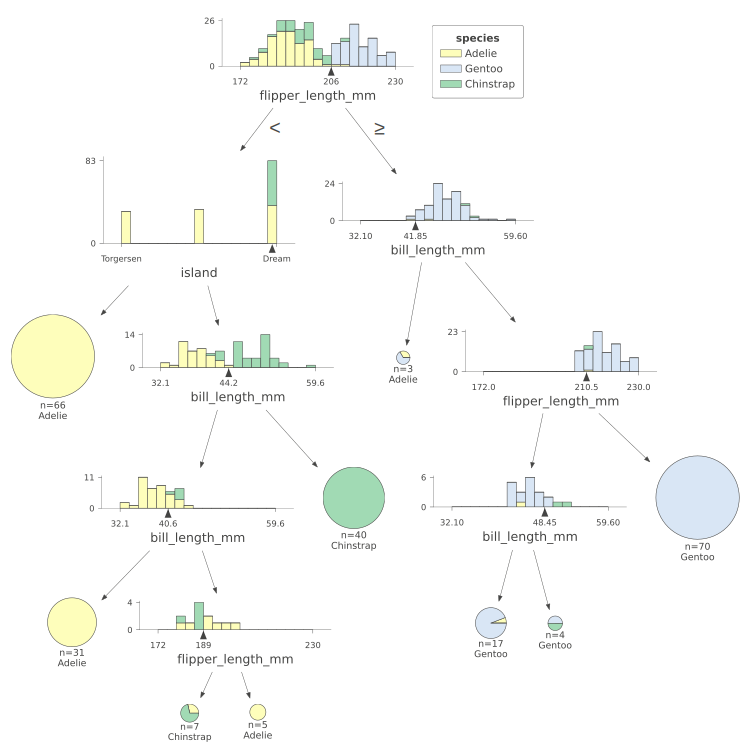

In [19]:
viz_cmodel.view(scale=1.4)

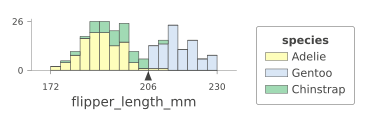

In [20]:
viz_cmodel.view(depth_range_to_display=[0,0], scale=1.5)

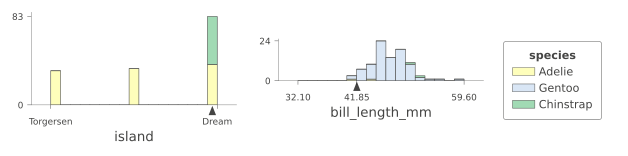

In [21]:
viz_cmodel.view(depth_range_to_display=[1,1], scale=1.5)

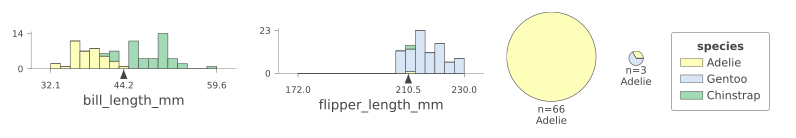

In [22]:
viz_cmodel.view(depth_range_to_display=[2,2], scale=1.5)

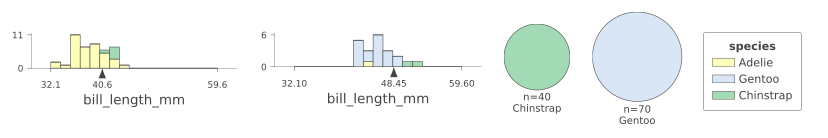

In [23]:
viz_cmodel.view(depth_range_to_display=[3,3], scale=1.5)

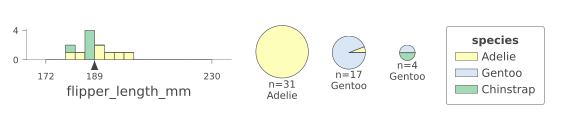

In [24]:
viz_cmodel.view(depth_range_to_display=[4,4], scale=1.5)

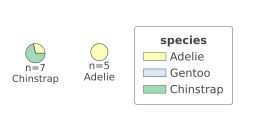

In [25]:
viz_cmodel.view(depth_range_to_display=[5,5], scale=1.5)

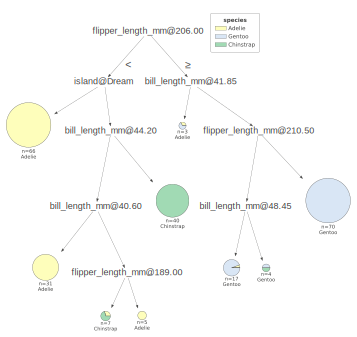

In [26]:
viz_cmodel.view(fancy=False, scale=.75)

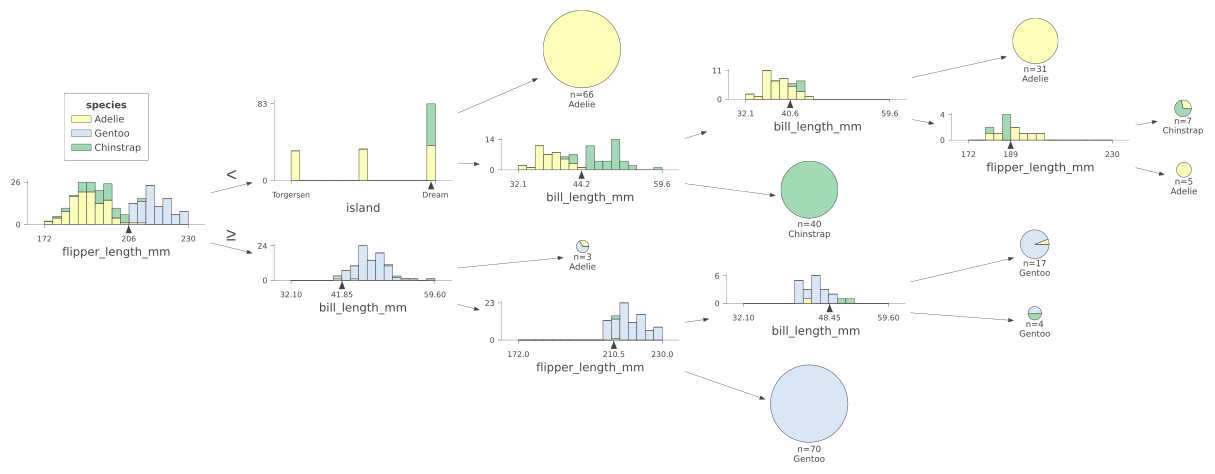

In [31]:
viz_cmodel.view(orientation='LR', scale=1.3)

Examining leaf stats

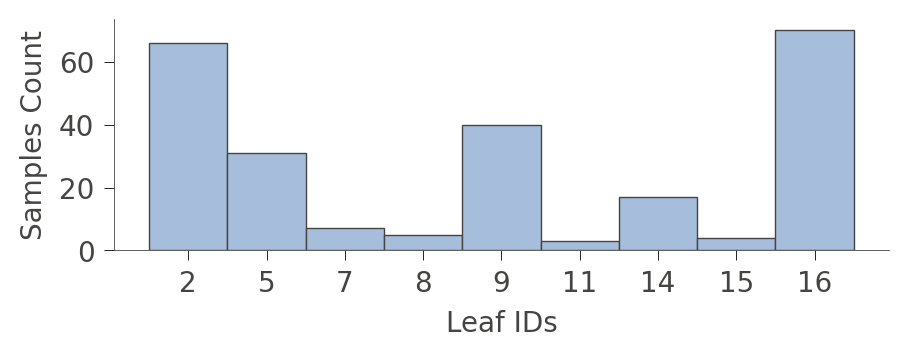

In [32]:
viz_cmodel.leaf_sizes(figsize=(5,1.5))

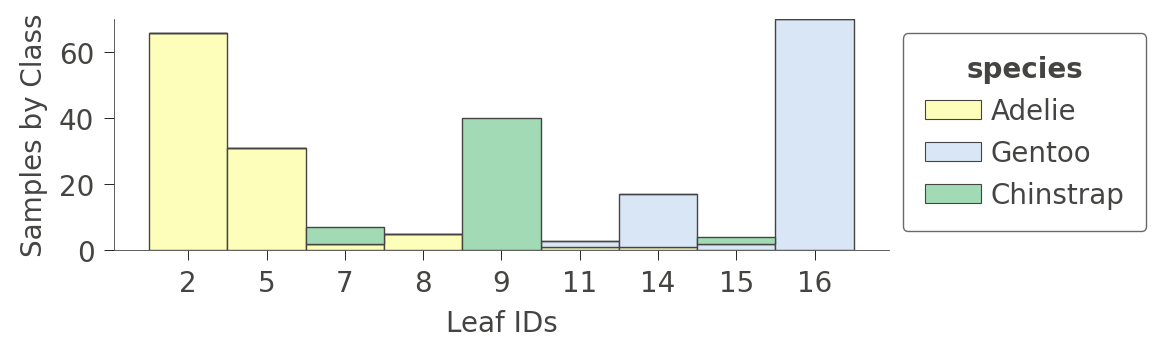

In [33]:
viz_cmodel.ctree_leaf_distributions(figsize=(5,1.5))

In [34]:
viz_cmodel.node_stats(node_id=5)

,bill_depth_mm,bill_length_mm,body_mass_g,flipper_length_mm,island,sex,year
count,31.0,31.0,31.0,31.0,31,31,31.0
unique,<NA>,<NA>,<NA>,<NA>,1,2,<NA>
top,<NA>,<NA>,<NA>,<NA>,Dream,female,<NA>
freq,<NA>,<NA>,<NA>,<NA>,31,19,<NA>
mean,18.090323,37.26129,3595.967742,189.0,NaN,NaN,2008.032258
std,1.216924,2.002778,471.173039,6.21289,NaN,NaN,0.836017
min,15.5,32.1,2900.0,178.0,NaN,NaN,2007.0
25%,17.2,36.25,3275.0,185.0,NaN,NaN,2007.0
50%,18.1,37.0,3500.0,189.0,NaN,NaN,2008.0
75%,18.65,38.95,3925.0,193.0,NaN,NaN,2009.0


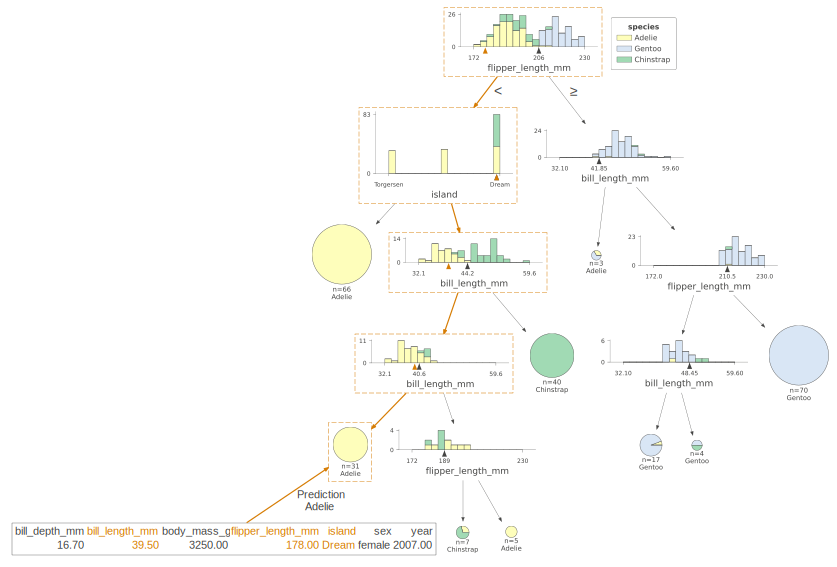

In [36]:
x = train_ds_pd[penguin_features].iloc[20]
viz_cmodel.view(x=x, scale=1)